In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, latent_dim * 2)
    
    def forward(self, x):
        h = self.fc(x)
        mu, logvar = torch.chunk(h, 2, dim=-1)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.fc = nn.Linear(latent_dim, output_dim)
    
    def forward(self, z):
        return self.fc(z)

class MMVAE(nn.Module):
    def __init__(self, input_dims, latent_dim, expert_type='poe'):
        super().__init__()
        self.encoders = nn.ModuleList([Encoder(dim, latent_dim) for dim in input_dims])
        self.decoders = nn.ModuleList([Decoder(latent_dim, dim) for dim in input_dims])
        self.expert_type = expert_type
    
    def encode(self, x_list):
        mu_list, logvar_list = zip(*[encoder(x) for encoder, x in zip(self.encoders, x_list)])
        return torch.stack(mu_list), torch.stack(logvar_list)
    
    def product_of_experts(self, mu, logvar):
        var = torch.exp(logvar)
        T = 1. / var
        pd_mu = torch.sum(mu * T, dim=0) / torch.sum(T, dim=0)
        pd_var = 1. / torch.sum(T, dim=0)
        pd_logvar = torch.log(pd_var)
        return pd_mu, pd_logvar
    
    def mixture_of_experts(self, mu, logvar):
        k = mu.shape[0]
        weights = torch.ones(k) / k
        idx = torch.multinomial(weights, 1).item()
        return mu[idx], logvar[idx]
    
    def mopoe(self, mu, logvar):
        poe_mu, poe_logvar = self.product_of_experts(mu, logvar)
        moe_mu, moe_logvar = self.mixture_of_experts(mu, logvar)
        alpha = 0.5  # Adjustable parameter
        final_mu = alpha * poe_mu + (1 - alpha) * moe_mu
        final_logvar = alpha * poe_logvar + (1 - alpha) * moe_logvar
        return final_mu, final_logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x_list):
        mu, logvar = self.encode(x_list)
        
        if self.expert_type == 'poe':
            mu, logvar = self.product_of_experts(mu, logvar)
        elif self.expert_type == 'moe':
            mu, logvar = self.mixture_of_experts(mu, logvar)
        elif self.expert_type == 'mopoe':
            mu, logvar = self.mopoe(mu, logvar)
        
        z = self.reparameterize(mu, logvar)
        reconstructions = [decoder(z) for decoder in self.decoders]
        return reconstructions, mu, logvar

# Example usage
input_dims = [784, 100]  # e.g., for MNIST image (28x28) and text feature
latent_dim = 20

poe_model = MMVAE(input_dims, latent_dim, expert_type='poe')
moe_model = MMVAE(input_dims, latent_dim, expert_type='moe')
mopoe_model = MMVAE(input_dims, latent_dim, expert_type='mopoe')

# Simulate input data
x1 = torch.randn(1, 784)
x2 = torch.randn(1, 100)

# Forward pass for each model
poe_output = poe_model([x1, x2])
moe_output = moe_model([x1, x2])
mopoe_output = mopoe_model([x1, x2])

print("PoE output shapes:", [o.shape for o in poe_output[0]])
print("MoE output shapes:", [o.shape for o in moe_output[0]])
print("MoPoE output shapes:", [o.shape for o in mopoe_output[0]])

PoE output shapes: [torch.Size([1, 784]), torch.Size([1, 100])]
MoE output shapes: [torch.Size([1, 784]), torch.Size([1, 100])]
MoPoE output shapes: [torch.Size([1, 784]), torch.Size([1, 100])]


Training PoE model...
Epoch 0: Average loss = 21.9850
Epoch 10: Average loss = 17.1265
Epoch 20: Average loss = 17.0952
Epoch 30: Average loss = 17.1263
Epoch 40: Average loss = 17.1018
Epoch 50: Average loss = 17.0883
Epoch 60: Average loss = 17.0725
Epoch 70: Average loss = 17.0370
Epoch 80: Average loss = 17.0900
Epoch 90: Average loss = 17.0728
Training MoE model...
Epoch 0: Average loss = 26.7351
Epoch 10: Average loss = 17.6772
Epoch 20: Average loss = 17.6038
Epoch 30: Average loss = 17.5042
Epoch 40: Average loss = 17.5329
Epoch 50: Average loss = 17.4996
Epoch 60: Average loss = 17.5931
Epoch 70: Average loss = 17.5796
Epoch 80: Average loss = 17.5690
Epoch 90: Average loss = 17.5712
Training MoPoE model...
Epoch 0: Average loss = 22.6736
Epoch 10: Average loss = 17.2522
Epoch 20: Average loss = 17.2499
Epoch 30: Average loss = 17.2390
Epoch 40: Average loss = 17.1873
Epoch 50: Average loss = 17.2194
Epoch 60: Average loss = 17.2481
Epoch 70: Average loss = 17.2399
Epoch 80: A

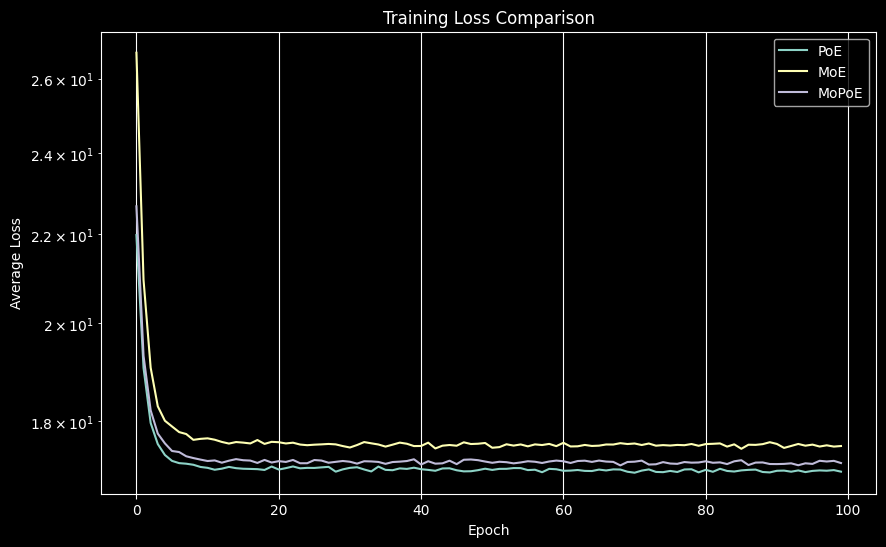

Evaluation Loss - PoE: 17.0715, MoE: 17.5263, MoPoE: 17.1770


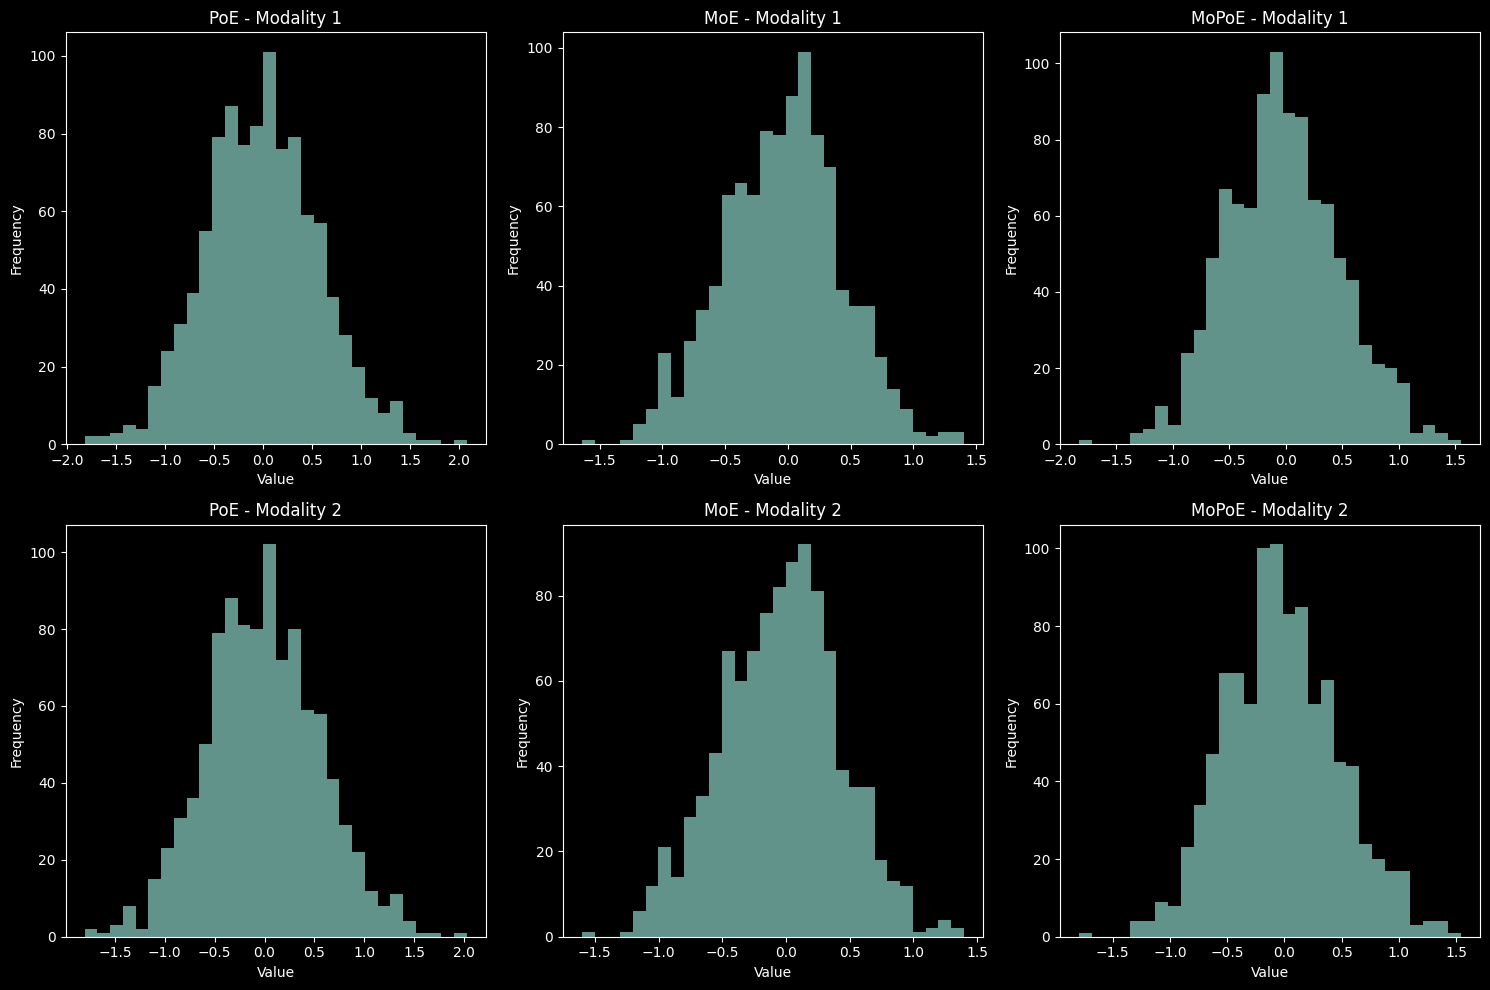

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Generate synthetic data
def generate_correlated_data(n_samples, dim1, dim2, correlation):
    data1 = torch.randn(n_samples, dim1)
    data2 = torch.randn(n_samples, dim2)
    correlation_tensor = torch.tensor(correlation)
    data2 = correlation_tensor * data1[:, :dim2] + torch.sqrt(1 - correlation_tensor**2) * data2
    return data1, data2

n_samples = 10000
input_dim1, input_dim2 = 10, 8
latent_dim = 5
correlation = 0.7

data1, data2 = generate_correlated_data(n_samples, input_dim1, input_dim2, correlation)
dataset = TensorDataset(data1, data2)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training function
def train_model(model, dataloader, optimizer, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx, (data1, data2) in enumerate(dataloader):
            optimizer.zero_grad()
            recon, mu, logvar = model([data1, data2])
            loss = sum(loss_function(recon[i], data, mu, logvar) for i, data in enumerate([data1, data2]))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(dataloader.dataset)
        losses.append(avg_loss)
        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Average loss = {avg_loss:.4f}')
    return losses

# Initialize models
poe_model = MMVAE([input_dim1, input_dim2], latent_dim, expert_type='poe')
moe_model = MMVAE([input_dim1, input_dim2], latent_dim, expert_type='moe')
mopoe_model = MMVAE([input_dim1, input_dim2], latent_dim, expert_type='mopoe')

# Train models
epochs = 100
lr = 1e-3

poe_optimizer = optim.Adam(poe_model.parameters(), lr=lr)
moe_optimizer = optim.Adam(moe_model.parameters(), lr=lr)
mopoe_optimizer = optim.Adam(mopoe_model.parameters(), lr=lr)

print("Training PoE model...")
poe_losses = train_model(poe_model, dataloader, poe_optimizer, epochs)

print("Training MoE model...")
moe_losses = train_model(moe_model, dataloader, moe_optimizer, epochs)

print("Training MoPoE model...")
mopoe_losses = train_model(mopoe_model, dataloader, mopoe_optimizer, epochs)

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(poe_losses, label='PoE')
plt.plot(moe_losses, label='MoE')
plt.plot(mopoe_losses, label='MoPoE')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_idx, (data1, data2) in enumerate(dataloader):
            recon, mu, logvar = model([data1, data2])
            loss = sum(loss_function(recon[i], data, mu, logvar) for i, data in enumerate([data1, data2]))
            total_loss += loss.item()
    return total_loss / len(dataloader.dataset)

# Evaluate models
poe_eval_loss = evaluate_model(poe_model, dataloader)
moe_eval_loss = evaluate_model(moe_model, dataloader)
mopoe_eval_loss = evaluate_model(mopoe_model, dataloader)

print(f"Evaluation Loss - PoE: {poe_eval_loss:.4f}, MoE: {moe_eval_loss:.4f}, MoPoE: {mopoe_eval_loss:.4f}")

# Generate samples
def generate_samples(model, n_samples):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim)
        samples = [decoder(z) for decoder in model.decoders]
    return samples

poe_samples = generate_samples(poe_model, 1000)
moe_samples = generate_samples(moe_model, 1000)
mopoe_samples = generate_samples(mopoe_model, 1000)

# Plot sample distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, (samples, title) in enumerate(zip([poe_samples, moe_samples, mopoe_samples], ['PoE', 'MoE', 'MoPoE'])):
    for j, modality in enumerate(['Modality 1', 'Modality 2']):
        axes[j, i].hist(samples[j][:, 0].numpy(), bins=30, alpha=0.7)
        axes[j, i].set_title(f'{title} - {modality}')
        axes[j, i].set_xlabel('Value')
        axes[j, i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Training PoE model...
Epoch 0: Average loss = 22.4200
Epoch 10: Average loss = 17.1983
Epoch 20: Average loss = 17.1445
Epoch 30: Average loss = 17.2087
Epoch 40: Average loss = 17.1403
Epoch 50: Average loss = 17.1878
Epoch 60: Average loss = 17.1029
Epoch 70: Average loss = 17.1233
Epoch 80: Average loss = 17.1577
Epoch 90: Average loss = 17.1242
Training MoE model...
Epoch 0: Average loss = 26.1223
Epoch 10: Average loss = 17.7345
Epoch 20: Average loss = 17.6420
Epoch 30: Average loss = 17.6529
Epoch 40: Average loss = 17.6213
Epoch 50: Average loss = 17.6437
Epoch 60: Average loss = 17.5820
Epoch 70: Average loss = 17.6526
Epoch 80: Average loss = 17.6671
Epoch 90: Average loss = 17.6160
Training MoPoE model...
Epoch 0: Average loss = 23.4093
Epoch 10: Average loss = 17.3312
Epoch 20: Average loss = 17.3796
Epoch 30: Average loss = 17.3192
Epoch 40: Average loss = 17.3360
Epoch 50: Average loss = 17.3487
Epoch 60: Average loss = 17.3215
Epoch 70: Average loss = 17.2624
Epoch 80: A

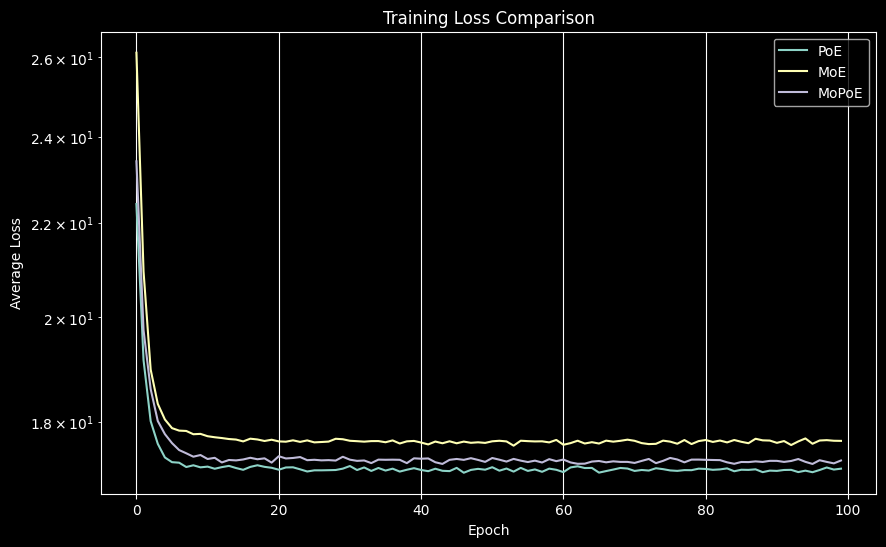

Learned PoE modality weights: [0.5 0.5]
Learned MoE modality weights: [0.5 0.5]
Learned MoPoE modality weights: [0.5 0.5]


NameError: name 'evaluate_model' is not defined

In [3]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torch.nn.functional as F  # Add this line

class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, latent_dim * 2)
    
    def forward(self, x):
        h = self.fc(x)
        mu, logvar = torch.chunk(h, 2, dim=-1)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.fc = nn.Linear(latent_dim, output_dim)
    
    def forward(self, z):
        return self.fc(z)

class MMVAE(nn.Module):
    def __init__(self, input_dims, latent_dim, expert_type='poe'):
        super().__init__()
        self.encoders = nn.ModuleList([Encoder(dim, latent_dim) for dim in input_dims])
        self.decoders = nn.ModuleList([Decoder(latent_dim, dim) for dim in input_dims])
        self.expert_type = expert_type
        self.modality_weights = nn.Parameter(torch.ones(len(input_dims)))
    
    def encode(self, x_list):
        mu_list, logvar_list = zip(*[encoder(x) for encoder, x in zip(self.encoders, x_list)])
        return torch.stack(mu_list), torch.stack(logvar_list)
    
    def product_of_experts(self, mu, logvar):
        var = torch.exp(logvar)
        T = 1. / var
        pd_mu = torch.sum(mu * T, dim=0) / torch.sum(T, dim=0)
        pd_var = 1. / torch.sum(T, dim=0)
        pd_logvar = torch.log(pd_var)
        return pd_mu, pd_logvar
    
    def mixture_of_experts(self, mu, logvar):
        weights = F.softmax(self.modality_weights, dim=0)
        idx = torch.multinomial(weights, 1).item()
        return mu[idx], logvar[idx]
    
    def mopoe(self, mu, logvar):
        poe_mu, poe_logvar = self.product_of_experts(mu, logvar)
        moe_mu, moe_logvar = self.mixture_of_experts(mu, logvar)
        alpha = 0.5  # Adjustable parameter
        final_mu = alpha * poe_mu + (1 - alpha) * moe_mu
        final_logvar = alpha * poe_logvar + (1 - alpha) * moe_logvar
        return final_mu, final_logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x_list):
        mu, logvar = self.encode(x_list)
        
        if self.expert_type == 'poe':
            mu, logvar = self.product_of_experts(mu, logvar)
        elif self.expert_type == 'moe':
            mu, logvar = self.mixture_of_experts(mu, logvar)
        elif self.expert_type == 'mopoe':
            mu, logvar = self.mopoe(mu, logvar)
        
        z = self.reparameterize(mu, logvar)
        reconstructions = [decoder(z) for decoder in self.decoders]
        return reconstructions, mu, logvar

# Generate synthetic data
def generate_correlated_data(n_samples, dim1, dim2, correlation):
    data1 = torch.randn(n_samples, dim1)
    data2 = torch.randn(n_samples, dim2)
    correlation_tensor = torch.tensor(correlation)
    data2 = correlation_tensor * data1[:, :dim2] + torch.sqrt(1 - correlation_tensor**2) * data2
    return data1, data2

n_samples = 10000
input_dim1, input_dim2 = 10, 8
latent_dim = 5
correlation = 0.7

data1, data2 = generate_correlated_data(n_samples, input_dim1, input_dim2, correlation)
dataset = TensorDataset(data1, data2)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training function
def train_model(model, dataloader, optimizer, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx, (data1, data2) in enumerate(dataloader):
            optimizer.zero_grad()
            recon, mu, logvar = model([data1, data2])
            loss = sum(loss_function(recon[i], data, mu, logvar) for i, data in enumerate([data1, data2]))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(dataloader.dataset)
        losses.append(avg_loss)
        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Average loss = {avg_loss:.4f}')
    return losses

# Initialize models
poe_model = MMVAE([input_dim1, input_dim2], latent_dim, expert_type='poe')
moe_model = MMVAE([input_dim1, input_dim2], latent_dim, expert_type='moe')
mopoe_model = MMVAE([input_dim1, input_dim2], latent_dim, expert_type='mopoe')

# Train models
epochs = 100
lr = 1e-3

poe_optimizer = optim.Adam(poe_model.parameters(), lr=lr)
moe_optimizer = optim.Adam(moe_model.parameters(), lr=lr)
mopoe_optimizer = optim.Adam(mopoe_model.parameters(), lr=lr)

print("Training PoE model...")
poe_losses = train_model(poe_model, dataloader, poe_optimizer, epochs)

print("Training MoE model...")
moe_losses = train_model(moe_model, dataloader, moe_optimizer, epochs)

print("Training MoPoE model...")
mopoe_losses = train_model(mopoe_model, dataloader, mopoe_optimizer, epochs)


# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(poe_losses, label='PoE')
plt.plot(moe_losses, label='MoE')
plt.plot(mopoe_losses, label='MoPoE')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

# After training, print learned weights for all models
for model_name, model in [("PoE", poe_model), ("MoE", moe_model), ("MoPoE", mopoe_model)]:
    weights = F.softmax(model.modality_weights, dim=0)
    print(f"Learned {model_name} modality weights:", weights.detach().numpy())
    
# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_idx, (data1, data2) in enumerate(dataloader):
            recon, mu, logvar = model([data1, data2])
            loss = sum(loss_function(recon[i], data, mu, logvar) for i, data in enumerate([data1, data2]))
            total_loss += loss.item()
    return total_loss / len(dataloader.dataset)

# Evaluate models
poe_eval_loss = evaluate_model(poe_model, dataloader)
moe_eval_loss = evaluate_model(moe_model, dataloader)
mopoe_eval_loss = evaluate_model(mopoe_model, dataloader)

print(f"Evaluation Loss - PoE: {poe_eval_loss:.4f}, MoE: {moe_eval_loss:.4f}, MoPoE: {mopoe_eval_loss:.4f}")

# Generate samples
def generate_samples(model, n_samples):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim)
        samples = [decoder(z) for decoder in model.decoders]
    return samples

poe_samples = generate_samples(poe_model, 1000)
moe_samples = generate_samples(moe_model, 1000)
mopoe_samples = generate_samples(mopoe_model, 1000)

# Plot sample distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, (samples, title) in enumerate(zip([poe_samples, moe_samples, mopoe_samples], ['PoE', 'MoE', 'MoPoE'])):
    for j, modality in enumerate(['Modality 1', 'Modality 2']):
        axes[j, i].hist(samples[j][:, 0].numpy(), bins=30, alpha=0.7)
        axes[j, i].set_title(f'{title} - {modality}')
        axes[j, i].set_xlabel('Value')
        axes[j, i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Evaluation Loss - PoE: 17.1126, MoE: 17.6031, MoPoE: 17.2149


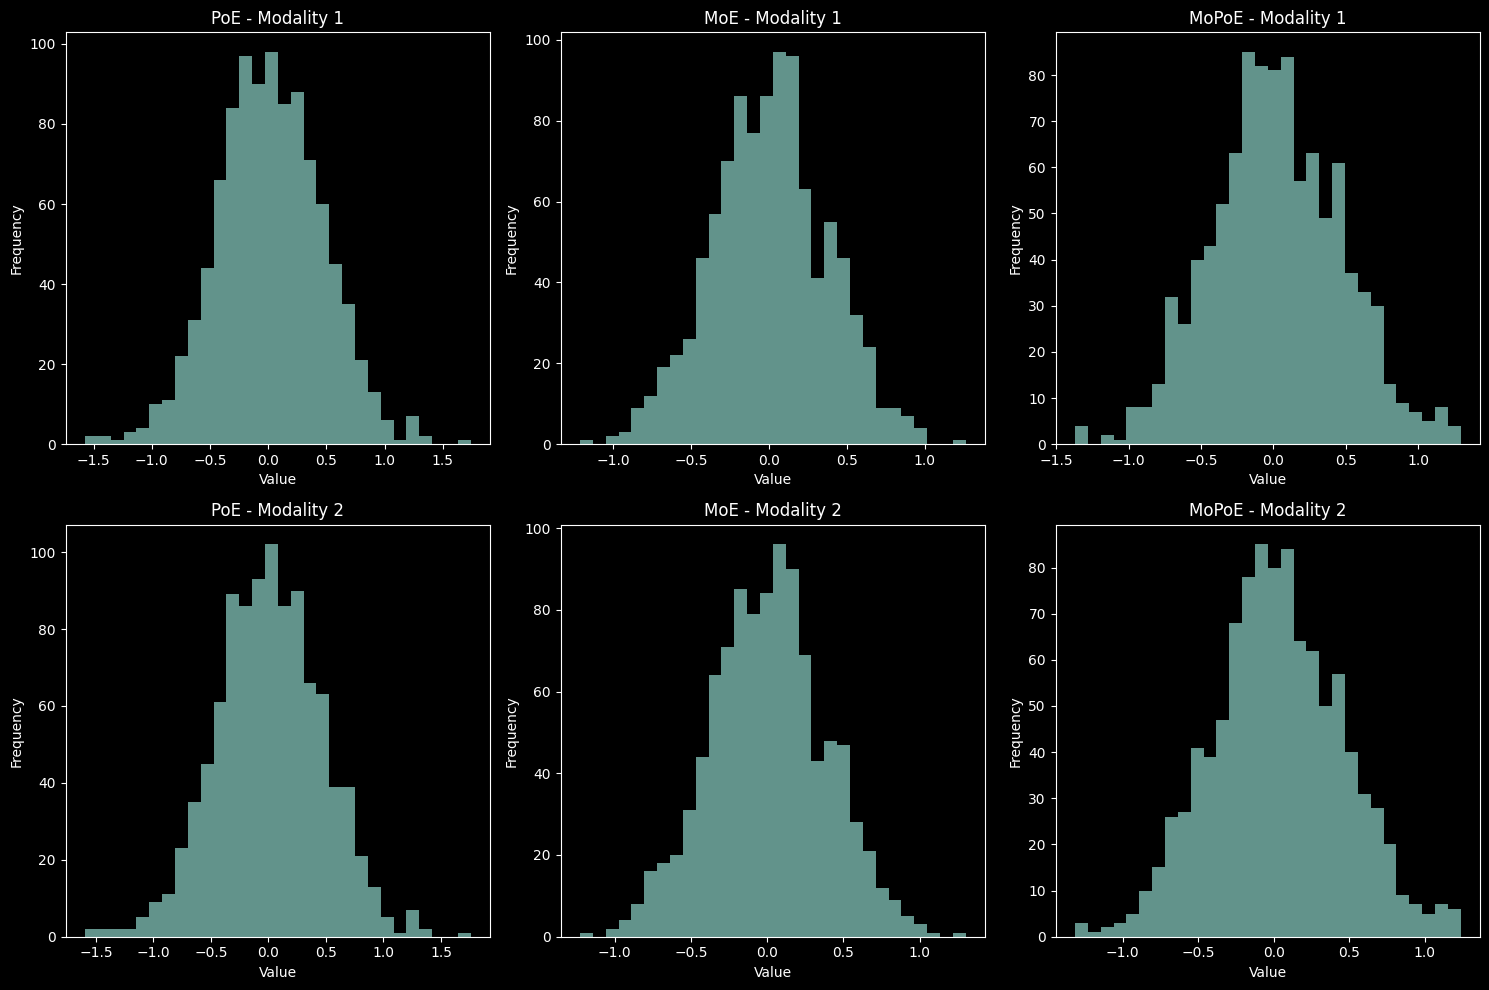

In [4]:
# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_idx, (data1, data2) in enumerate(dataloader):
            recon, mu, logvar = model([data1, data2])
            loss = sum(loss_function(recon[i], data, mu, logvar) for i, data in enumerate([data1, data2]))
            total_loss += loss.item()
    return total_loss / len(dataloader.dataset)


# Evaluate models
poe_eval_loss = evaluate_model(poe_model, dataloader)
moe_eval_loss = evaluate_model(moe_model, dataloader)
mopoe_eval_loss = evaluate_model(mopoe_model, dataloader)

print(f"Evaluation Loss - PoE: {poe_eval_loss:.4f}, MoE: {moe_eval_loss:.4f}, MoPoE: {mopoe_eval_loss:.4f}")

# Generate samples
def generate_samples(model, n_samples):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim)
        samples = [decoder(z) for decoder in model.decoders]
    return samples

poe_samples = generate_samples(poe_model, 1000)
moe_samples = generate_samples(moe_model, 1000)
mopoe_samples = generate_samples(mopoe_model, 1000)

# Plot sample distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, (samples, title) in enumerate(zip([poe_samples, moe_samples, mopoe_samples], ['PoE', 'MoE', 'MoPoE'])):
    for j, modality in enumerate(['Modality 1', 'Modality 2']):
        axes[j, i].hist(samples[j][:, 0].numpy(), bins=30, alpha=0.7)
        axes[j, i].set_title(f'{title} - {modality}')
        axes[j, i].set_xlabel('Value')
        axes[j, i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_logvar = nn.Linear(32, latent_dim)
    
    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc_mu(h), self.fc_logvar(h)

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, output_dim)
    
    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        return self.fc3(h)

class MMVAEPlusPlus(nn.Module):
    def __init__(self, input_dims, shared_dim, specific_dim):
        super().__init__()
        self.encoders = nn.ModuleList([Encoder(dim, shared_dim + specific_dim) for dim in input_dims])
        self.decoders = nn.ModuleList([Decoder(shared_dim + specific_dim, dim) for dim in input_dims])
        self.shared_dim = shared_dim
        self.specific_dim = specific_dim
    
    def encode(self, x_list):
        return [encoder(x) for encoder, x in zip(self.encoders, x_list)]
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z_list):
        return [decoder(z) for decoder, z in zip(self.decoders, z_list)]
    
    def forward(self, x_list):
        # Encode
        mu_logvar_list = self.encode(x_list)
        
        # Split into shared and specific components
        mu_shared_list = [mu_logvar[0][:, :self.shared_dim] for mu_logvar in mu_logvar_list]
        logvar_shared_list = [mu_logvar[1][:, :self.shared_dim] for mu_logvar in mu_logvar_list]
        mu_specific_list = [mu_logvar[0][:, self.shared_dim:] for mu_logvar in mu_logvar_list]
        logvar_specific_list = [mu_logvar[1][:, self.shared_dim:] for mu_logvar in mu_logvar_list]
        
        # Combine shared components
        mu_shared = torch.stack(mu_shared_list).mean(dim=0)
        logvar_shared = torch.stack(logvar_shared_list).mean(dim=0)
        
        # Reparameterize
        z_shared = self.reparameterize(mu_shared, logvar_shared)
        z_specific_list = [self.reparameterize(mu, logvar) for mu, logvar in zip(mu_specific_list, logvar_specific_list)]
        
        # Combine shared and specific latents
        z_combined_list = [torch.cat([z_shared, z_specific], dim=1) for z_specific in z_specific_list]
        
        # Decode
        reconstructions = self.decode(z_combined_list)
        
        return reconstructions, (mu_shared, logvar_shared, mu_specific_list, logvar_specific_list)

# Loss function
def loss_function(recon_x_list, x_list, mu_shared, logvar_shared, mu_specific_list, logvar_specific_list):
    # Reconstruction loss
    recon_loss = sum(F.mse_loss(recon_x, x, reduction='sum') for recon_x, x in zip(recon_x_list, x_list))
    
    # KL divergence for shared latent
    kld_shared = -0.5 * torch.sum(1 + logvar_shared - mu_shared.pow(2) - logvar_shared.exp())
    
    # KL divergence for specific latents
    kld_specific = sum(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) 
                       for mu, logvar in zip(mu_specific_list, logvar_specific_list))
    
    return recon_loss + kld_shared + kld_specific

# Generate synthetic data
def generate_correlated_data(n_samples, dim1, dim2, shared_dim, specific_dim):
    shared = torch.randn(n_samples, shared_dim)
    specific1 = torch.randn(n_samples, specific_dim)
    specific2 = torch.randn(n_samples, specific_dim)
    
    data1 = torch.cat([shared, specific1], dim=1)
    data2 = torch.cat([shared, specific2], dim=1)
    
    return data1, data2

# Training function
def train(model, optimizer, data_loader, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data1, data2) in enumerate(data_loader):
            optimizer.zero_grad()
            recon_x_list, (mu_shared, logvar_shared, mu_specific_list, logvar_specific_list) = model([data1, data2])
            loss = loss_function(recon_x_list, [data1, data2], mu_shared, logvar_shared, mu_specific_list, logvar_specific_list)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f'Epoch {epoch+1}, Average loss: {total_loss / len(data_loader.dataset):.4f}')

# Main execution
if __name__ == "__main__":
    # Set parameters
    input_dim1, input_dim2 = 5, 5  # Changed from 10, 8 to match generated data
    shared_dim, specific_dim = 3, 2
    batch_size = 64
    epochs = 50
    
    # Generate data
    data1, data2 = generate_correlated_data(1000, input_dim1, input_dim2, shared_dim, specific_dim)
    dataset = torch.utils.data.TensorDataset(data1, data2)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model
    model = MMVAEPlusPlus([input_dim1, input_dim2], shared_dim, specific_dim)
    optimizer = optim.Adam(model.parameters())
    
    # Train model
    train(model, optimizer, data_loader, epochs)
    
    # Demonstrate disentanglement
    model.eval()
    with torch.no_grad():
        test_data1, test_data2 = next(iter(data_loader))
        recon, (mu_shared, logvar_shared, mu_specific_list, logvar_specific_list) = model([test_data1, test_data2])
        
        print("\nShared latent representation:")
        print(mu_shared[0])
        
        print("\nSpecific latent representation for modality 1:")
        print(mu_specific_list[0][0])
        
        print("\nSpecific latent representation for modality 2:")
        print(mu_specific_list[1][0])

Epoch 1, Average loss: 10.0661
Epoch 2, Average loss: 9.9254
Epoch 3, Average loss: 9.9169
Epoch 4, Average loss: 9.8809
Epoch 5, Average loss: 9.7905
Epoch 6, Average loss: 9.7046
Epoch 7, Average loss: 9.4350
Epoch 8, Average loss: 9.1782
Epoch 9, Average loss: 8.9878
Epoch 10, Average loss: 8.6278
Epoch 11, Average loss: 8.4535
Epoch 12, Average loss: 8.2517
Epoch 13, Average loss: 7.9779
Epoch 14, Average loss: 7.7353
Epoch 15, Average loss: 7.6747
Epoch 16, Average loss: 7.5195
Epoch 17, Average loss: 7.5343
Epoch 18, Average loss: 7.4461
Epoch 19, Average loss: 7.4096
Epoch 20, Average loss: 7.3186
Epoch 21, Average loss: 7.2623
Epoch 22, Average loss: 7.2257
Epoch 23, Average loss: 7.2821
Epoch 24, Average loss: 7.3144
Epoch 25, Average loss: 7.2552
Epoch 26, Average loss: 7.1952
Epoch 27, Average loss: 7.0935
Epoch 28, Average loss: 7.1486
Epoch 29, Average loss: 7.2011
Epoch 30, Average loss: 7.1195
Epoch 31, Average loss: 7.0425
Epoch 32, Average loss: 7.0391
Epoch 33, Averag